(array([0.21998051, 0.04397812, 0.03804395, 0.04962798, 0.04260562]),
 array([0.21998051, 0.05082938, 0.05806494, 0.057676  , 0.05337962,
        0.06361728]))

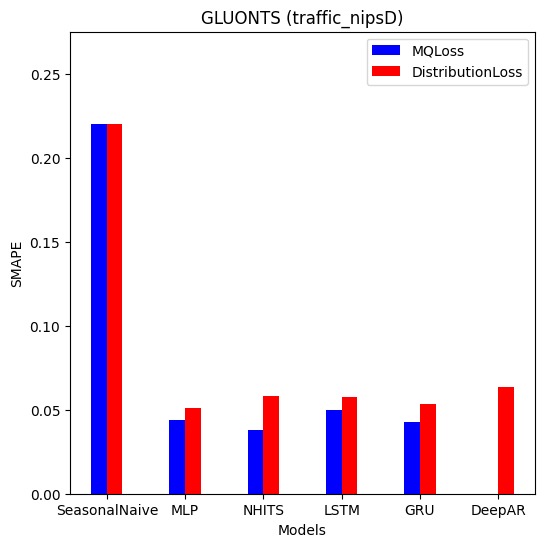

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from codebase.load_data.m3 import M3Dataset
from codebase.load_data.tourism import TourismDataset
from codebase.load_data.gluonts import GluontsDataset
from matplotlib.pyplot import close

def plot_smape(dataset_name, group):

    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']

    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results") :
        return

    MQL = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/smape_{dataset_name}_{group}_MQLoss.csv")
    DL = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/smape_{dataset_name}_{group}_DistributionLoss.csv")

    MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in MQL.columns]
    DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in DL.columns]

    MQL_means = MQL.drop(columns='unique_id').mean()
    DL_means = DL.drop(columns='unique_id').mean()

    y_max = max(MQL_means.max(), DL_means.max())

    combined_means = pd.concat([MQL_means, DL_means], axis=1)
    combined_means.columns = ['MQL', 'DL']

    fig, ax = plt.subplots(figsize=(6, 6))

    bar_width = 0.2
    index = np.arange(len(combined_means))

    bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
    bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

    ax.set_xlabel('Models')
    ax.set_ylabel('SMAPE')
    ax.set_ylim(0, 1.25*y_max)
    ax.set_title(f'{dataset_name} ({group})')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(combined_means.index)
    ax.legend(loc='upper right')

    plt.savefig(f"plots/smape/smape_{dataset_name}_{group}.png")

    return MQL_means.values, DL_means.values

plot_smape("GLUONTS", "traffic_nips")

array([[0.89377469, 0.89377469,        nan],
       [0.9442997 , 0.94901607, 0.93037096],
       [0.94258154, 0.94764076, 0.93067706],
       [0.93885728, 0.94210347, 0.92344561],
       [0.94210786, 0.94710105, 0.9250146 ],
       [       nan, 0.90909188,        nan]])

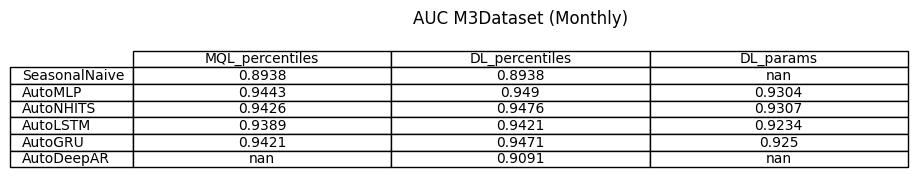

In [92]:
def plot_auc(dataset_name, group):
    
    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']

    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results"):
        return
    
    MQL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        auc_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        #for model in ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU', 'DeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
            auc_means[model] = auc
        matrix[df_name] = auc_means

    auc_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
    plt.title(f'AUC {dataset_name} ({group})')
    plt.savefig(f"plots/auc/auc_{dataset_name}_{group}.png")

    return auc_df.values

plot_auc("M3Dataset", "Monthly")

array([[0.37905244, 0.37905244,        nan],
       [0.26756358, 0.25498192, 0.52334145],
       [0.26999005, 0.25907744, 0.52251466],
       [0.2781018 , 0.26865399, 0.5230386 ],
       [0.2686623 , 0.26334129, 0.52593263],
       [       nan, 0.39126534,        nan]])

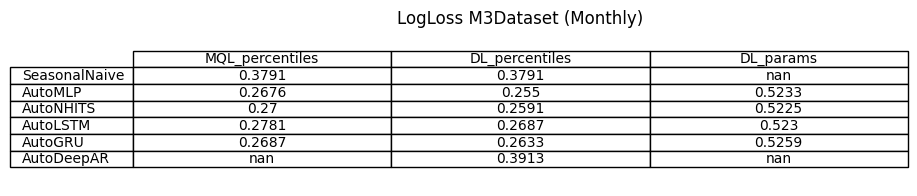

In [93]:
def plot_logloss(dataset_name, group):

    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']
    
    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results") :
        return
    
    MQL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        logloss_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        #for model in ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU', 'DeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
            logloss_means[model] = auc
        matrix[df_name] = logloss_means

    logloss_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=logloss_df.round(4).values, colLabels=logloss_df.columns, rowLabels=logloss_df.index, cellLoc='center', loc='center')
    plt.title(f'LogLoss {dataset_name} ({group})')
    plt.savefig(f"plots/logloss/logloss_{dataset_name}_{group}.png")

    return logloss_df.values

plot_logloss("M3Dataset", "Monthly")

In [94]:
os.system("rm ./plots/smape/* ./plots/auc/* ./plots/logloss/*")

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        print(dataset._DATASET_NAME, group)
        plot_smape(dataset._DATASET_NAME, group); close()
        plot_auc(dataset._DATASET_NAME, group); close()
        plot_logloss(dataset._DATASET_NAME, group); close()

M3Dataset Quarterly
M3Dataset Monthly
Tourism Quarterly
Tourism Monthly
GLUONTS car_parts_without_missing
GLUONTS electricity_weekly
GLUONTS traffic_nips


/tmp/ipykernel_748612/38213692.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
/tmp/ipykernel_748612/38213692.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


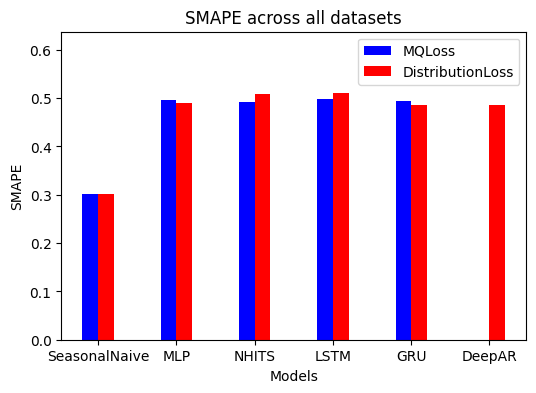

In [95]:
smape_global_MQL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU'])
smape_global_DL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU','DeepAR'])


for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
        
        smape_MQL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/smape_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        smape_DL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/smape_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")

        smape_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_MQL.columns]
        smape_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_DL.columns]

        smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
        smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


smape_global_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_MQL.columns]
smape_global_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_DL.columns]

MQL_means = smape_global_MQL.drop(columns='unique_id').mean()
DL_means = smape_global_DL.drop(columns='unique_id').mean()

y_max = max(MQL_means.max(), DL_means.max())

combined_means = pd.concat([MQL_means, DL_means], axis=1)
combined_means.columns = ['MQL', 'DL']

fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.2
index = np.arange(len(combined_means))

bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('SMAPE')
ax.set_ylim(0, 1.25*y_max)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_means.index)
ax.legend(loc='upper right')
ax.set_title("SMAPE across all datasets")
plt.savefig("plots/smape_global_mean.png")


/tmp/ipykernel_748612/1327856206.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_748612/1327856206.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_748612/1327856206.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a

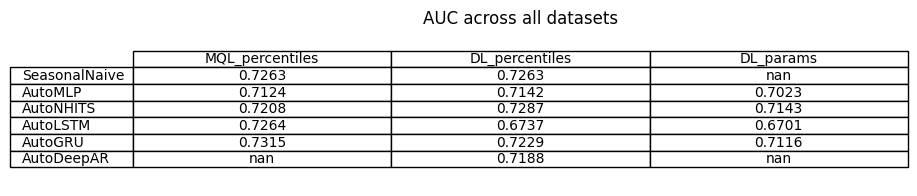

In [96]:
auc_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']

        MQL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
        auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
        auc_global_DL_params = pd.concat([auc_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', auc_global_MQL_percentiles), ("DL_percentiles", auc_global_DL_percentiles), ("DL_params", auc_global_DL_params)]:
    auc_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
        auc_means[model] = auc
    matrix[df_name] = auc_means

auc_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("AUC across all datasets")

table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
plt.savefig("plots/auc_global_mean.png")

/tmp/ipykernel_748612/2573241626.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logloss_global_MQL_percentiles = pd.concat([logloss_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_748612/2573241626.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logloss_global_DL_percentiles = pd.concat([logloss_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_748612/2573241626.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

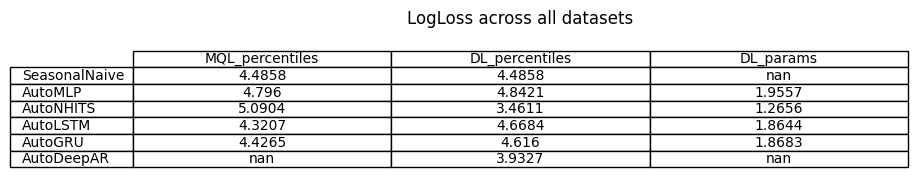

In [97]:
logloss_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
logloss_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
logloss_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
            
        MQL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        logloss_global_MQL_percentiles = pd.concat([logloss_global_MQL_percentiles, MQL_percentiles], axis=0)
        logloss_global_DL_percentiles = pd.concat([logloss_global_DL_percentiles, DL_percentiles], axis=0)
        logloss_global_DL_params = pd.concat([logloss_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', logloss_global_MQL_percentiles), ("DL_percentiles", logloss_global_DL_percentiles), ("DL_params", logloss_global_DL_params)]:
    logloss_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
        logloss_means[model] = auc
    matrix[df_name] = logloss_means

logloss_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("LogLoss across all datasets")

table = ax.table(cellText=logloss_df.round(4).values, colLabels=logloss_df.columns, rowLabels=logloss_df.index, cellLoc='center', loc='center')
plt.savefig("plots/logloss_global_mean.png")